Frame enumuration and submission to Hyp3 with Tropo, Iono, SET corrections.

In [2]:
%load_ext autoreload
%autoreload 2

In [48]:
from s1_frame_enumerator import (get_s1_stack, 
                                 filter_s1_stack_by_geometric_coverage_per_pass, 
                                 get_global_s1_frames, 
                                 get_overlapping_s1_frames, 
                                 enumerate_dates, 
                                 frames2gdf, 
                                 enumerate_gunw_time_series)
from shapely.geometry import Point
import geopandas as gpd
from rasterio.crs import CRS
import matplotlib.pyplot as plt
import warnings
import json
import pandas as pd
import datetime
from tqdm import tqdm

# CA

In [19]:
for x in df_ca.geometry[0].geoms:
    break

We only want the mainlain part.

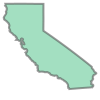

In [22]:
df_ca.geometry[0].geoms[-1]

<Axes: >

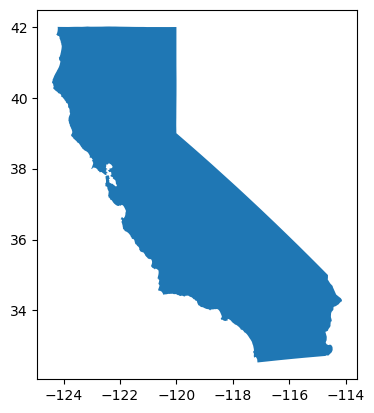

In [37]:
df_ca = gpd.read_file('https://raw.githubusercontent.com/ropensci/geojsonio/main/inst/examples/california.geojson')
df_ca.geometry = [df_ca.geometry[0].geoms[-1]]
df_ca.plot()

# Parameters

In [54]:
TEMPORAL_BASELINES_DAYS = [0, 30, 365]
WEATHER_MODEL = 'HRRR'
NEIGHBORS = 3

An erosion ensures not too many frames off the coast.

In [44]:
frames = get_overlapping_s1_frames(df_ca.geometry.unary_union.buffer(-.25))
df_frames_all = frames2gdf(frames)
df_frames_all.head()

,frame_id,track_number_min,track_number_max,geometry
0,1930,13,13,"POLYGON Z ((-126.01264 40.75129 0.00000, -125...."
1,1931,13,13,"POLYGON Z ((-126.25208 39.59170 0.00000, -126...."
2,1932,13,13,"POLYGON Z ((-126.48927 38.43175 0.00000, -126...."
3,5286,35,35,"POLYGON Z ((-123.00511 34.17223 0.00000, -123...."
4,5287,35,35,"POLYGON Z ((-123.28214 35.34912 0.00000, -123...."


In [45]:
all_tracks = df_frames_all.track_number_min.unique().tolist() + df_frames_all.track_number_max.unique().tolist()
all_tracks = sorted(list(set(all_tracks)))
all_tracks

[13, 35, 42, 64, 71, 93, 100, 108, 115, 137, 144, 166, 173]

(30.78421186522863, 43.88251499612947)

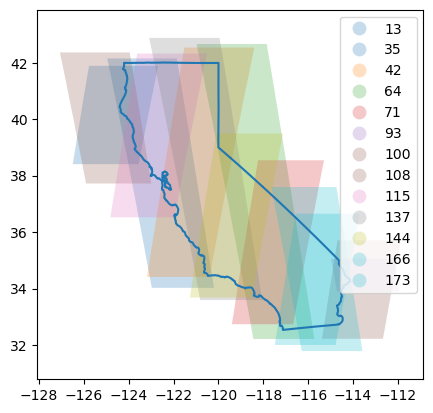

In [46]:
fig, ax = plt.subplots()
df_ca.boundary.plot(ax=ax)
df_frames_by_track = df_frames_all.dissolve(by='track_number_min').reset_index(drop=False)
df_frames_by_track.plot(ax=ax, 
                        column='track_number_min',
                        categorical=True,
                        alpha=.25, 
                        legend=True)
xmin, ymin, xmax, ymax = df_frames_by_track.total_bounds
ax.set_xlim(xmin - 1, xmax + 1)
ax.set_ylim(ymin - 1, ymax + 1)

# Get Stack from Frame

In [49]:
frames_for_each_track = [[f for f in frames if track in f.track_numbers] for track in all_tracks]

In [50]:
list_of_stacks = list(map(get_s1_stack, tqdm(frames_for_each_track)))

  8%|█▌                   | 1/13 [00:29<05:54, 29.52s/it]
/Users/cmarshak/bekaert-team/s1-frame-enumerator/s1_frame_enumerator/s1_stack.py:80: UserWarning: Frame 5286 did not have enough coverage on 2016-10-03 (ratio of coverage was 0.21)
  warn(f'Frame {frame.frame_id} did not have enough coverage '
/Users/cmarshak/bekaert-team/s1-frame-enumerator/s1_frame_enumerator/s1_stack.py:80: UserWarning: Frame 5286 did not have enough coverage on 2016-10-27 (ratio of coverage was 0.21)
  warn(f'Frame {frame.frame_id} did not have enough coverage '
/Users/cmarshak/bekaert-team/s1-frame-enumerator/s1_frame_enumerator/s1_stack.py:80: UserWarning: Frame 5286 did not have enough coverage on 2016-11-20 (ratio of coverage was 0.21)
  warn(f'Frame {frame.frame_id} did not have enough coverage '
/Users/cmarshak/bekaert-team/s1-frame-enumerator/s1_frame_enumerator/s1_stack.py:80: UserWarning: Frame 5286 did not have enough coverage on 2016-12-14 (ratio of coverage was 0.21)
  warn(f'Frame {frame.frame_i

100%|████████████████████| 13/13 [18:26<00:00, 85.08s/it]


There are numerous options if certain dates that are excluded should be included in the time series:

1. Lower some of the coverage ratios
2. Exclude the noted frames from consideration

Again, this is the common consideration of spatial coverage and temporal coverage (increasing one decreases the other and vice versa).

# Generate Pairs

In [55]:
all_submissions = []
for tb in tqdm(TEMPORAL_BASELINES_DAYS, desc='temporal baselines'):
    for frames, df_stack, track in zip(frames_for_each_track, list_of_stacks, tqdm(all_tracks[:])):

        data = enumerate_gunw_time_series(df_stack, 
                                          tb, 
                                          n_secondary_scenes_per_ref=NEIGHBORS,
                                          frames=frames 
                                         )
        submission_data = {'ifg_inputs': data,
                           'track': track,
                           'min_temporal_baseline': tb}
        all_submissions.append(submission_data)

  0%|                              | 0/1 [00:00<?, ?it/s]

Date Pairs:   0%|                | 0/621 [00:00<?, ?it/s]

Date Pairs:   0%|        | 2/621 [00:00<00:51, 12.07it/s]

Date Pairs:   1%|        | 4/621 [00:00<00:50, 12.31it/s]

Date Pairs:   1%|        | 6/621 [00:00<00:50, 12.07it/s]

Date Pairs:   1%|        | 8/621 [00:00<00:51, 11.93it/s]

Date Pairs:   2%|       | 10/621 [00:00<00:51, 11.81it/s]

Date Pairs:   2%|▏      | 12/621 [00:01<00:51, 11.76it/s]

Date Pairs:   2%|▏      | 14/621 [00:01<00:52, 11.66it/s]

Date Pairs:   3%|▏      | 16/621 [00:01<00:51, 11.73it/s]

Date Pairs:   3%|▏      | 18/621 [00:01<00:50, 11.94it/s]

Date Pairs:   3%|▏      | 20/621 [00:01<00:50, 11.98it/s]

Date Pairs:   4%|▏      | 22/621 [00:01<00:49, 12.08it/s]

Date Pairs:   4%|▎      | 24/621 [00:02<00:49, 12.15it/s]

Date Pairs:   4%|▎      | 26/621 [00:02<00:49, 11.93it/s]

Date Pairs:   5%|▎      | 28/621 [00:02<00:49, 12.05it/s]

Date Pairs:   5%|▎      | 30/621 [00:02<00:49, 11.94it/s

Date Pairs:  40%|██▍   | 248/621 [00:20<00:30, 12.20it/s]

Date Pairs:  40%|██▍   | 250/621 [00:20<00:30, 12.28it/s]

Date Pairs:  41%|██▍   | 252/621 [00:20<00:30, 12.26it/s]

Date Pairs:  41%|██▍   | 254/621 [00:20<00:30, 12.15it/s]

Date Pairs:  41%|██▍   | 256/621 [00:21<00:30, 12.13it/s]

Date Pairs:  42%|██▍   | 258/621 [00:21<00:29, 12.16it/s]

Date Pairs:  42%|██▌   | 260/621 [00:21<00:29, 12.21it/s]

Date Pairs:  42%|██▌   | 262/621 [00:21<00:29, 12.32it/s]

Date Pairs:  43%|██▌   | 264/621 [00:21<00:28, 12.40it/s]

Date Pairs:  43%|██▌   | 266/621 [00:21<00:28, 12.42it/s]

Date Pairs:  43%|██▌   | 268/621 [00:22<00:28, 12.24it/s]

Date Pairs:  43%|██▌   | 270/621 [00:22<00:28, 12.25it/s]

Date Pairs:  44%|██▋   | 272/621 [00:22<00:28, 12.19it/s]

Date Pairs:  44%|██▋   | 274/621 [00:22<00:28, 12.21it/s]

Date Pairs:  44%|██▋   | 276/621 [00:22<00:28, 12.21it/s]

Date Pairs:  45%|██▋   | 278/621 [00:22<00:27, 12.27it/s]

Date Pairs:  45%|██▋   | 280/621 [00:23<00:27, 12.28it/s

Date Pairs:  81%|████▊ | 500/621 [00:41<00:09, 12.18it/s]

Date Pairs:  81%|████▊ | 502/621 [00:41<00:09, 12.08it/s]

Date Pairs:  81%|████▊ | 504/621 [00:41<00:09, 12.13it/s]

Date Pairs:  81%|████▉ | 506/621 [00:41<00:09, 12.15it/s]

Date Pairs:  82%|████▉ | 508/621 [00:41<00:09, 12.17it/s]

Date Pairs:  82%|████▉ | 510/621 [00:41<00:09, 12.03it/s]

Date Pairs:  82%|████▉ | 512/621 [00:42<00:09, 12.04it/s]

Date Pairs:  83%|████▉ | 514/621 [00:42<00:08, 12.18it/s]

Date Pairs:  83%|████▉ | 516/621 [00:42<00:08, 12.07it/s]

Date Pairs:  83%|█████ | 518/621 [00:42<00:08, 12.09it/s]

Date Pairs:  84%|█████ | 520/621 [00:42<00:08, 12.21it/s]

Date Pairs:  84%|█████ | 522/621 [00:42<00:08, 12.21it/s]

Date Pairs:  84%|█████ | 524/621 [00:43<00:07, 12.18it/s]

Date Pairs:  85%|█████ | 526/621 [00:43<00:07, 12.11it/s]

Date Pairs:  85%|█████ | 528/621 [00:43<00:07, 12.03it/s]

Date Pairs:  85%|█████ | 530/621 [00:43<00:07, 12.04it/s]

Date Pairs:  86%|█████▏| 532/621 [00:43<00:07, 12.14it/s

Date Pairs:  20%|█▏    | 124/612 [00:10<00:41, 11.90it/s]

Date Pairs:  21%|█▏    | 126/612 [00:10<00:40, 11.94it/s]

Date Pairs:  21%|█▎    | 128/612 [00:10<00:40, 12.06it/s]

Date Pairs:  21%|█▎    | 130/612 [00:10<00:39, 12.17it/s]

Date Pairs:  22%|█▎    | 132/612 [00:10<00:39, 12.23it/s]

Date Pairs:  22%|█▎    | 134/612 [00:10<00:39, 12.18it/s]

Date Pairs:  22%|█▎    | 136/612 [00:11<00:38, 12.25it/s]

Date Pairs:  23%|█▎    | 138/612 [00:11<00:38, 12.29it/s]

Date Pairs:  23%|█▎    | 140/612 [00:11<00:38, 12.24it/s]

Date Pairs:  23%|█▍    | 142/612 [00:11<00:38, 12.23it/s]

Date Pairs:  24%|█▍    | 144/612 [00:11<00:38, 12.29it/s]

Date Pairs:  24%|█▍    | 146/612 [00:11<00:37, 12.30it/s]

Date Pairs:  24%|█▍    | 148/612 [00:12<00:37, 12.35it/s]

Date Pairs:  25%|█▍    | 150/612 [00:12<00:37, 12.35it/s]

Date Pairs:  25%|█▍    | 152/612 [00:12<00:37, 12.41it/s]

Date Pairs:  25%|█▌    | 154/612 [00:12<00:36, 12.41it/s]

Date Pairs:  25%|█▌    | 156/612 [00:12<00:36, 12.45it/s

Date Pairs:  61%|███▋  | 376/612 [00:30<00:19, 12.01it/s]

Date Pairs:  62%|███▋  | 378/612 [00:31<00:19, 12.15it/s]

Date Pairs:  62%|███▋  | 380/612 [00:31<00:19, 12.10it/s]

Date Pairs:  62%|███▋  | 382/612 [00:31<00:18, 12.14it/s]

Date Pairs:  63%|███▊  | 384/612 [00:31<00:18, 12.08it/s]

Date Pairs:  63%|███▊  | 386/612 [00:31<00:18, 12.18it/s]

Date Pairs:  63%|███▊  | 388/612 [00:31<00:18, 12.03it/s]

Date Pairs:  64%|███▊  | 390/612 [00:32<00:18, 12.15it/s]

Date Pairs:  64%|███▊  | 392/612 [00:32<00:18, 12.11it/s]

Date Pairs:  64%|███▊  | 394/612 [00:32<00:17, 12.13it/s]

Date Pairs:  65%|███▉  | 396/612 [00:32<00:17, 12.09it/s]

Date Pairs:  65%|███▉  | 398/612 [00:32<00:17, 12.11it/s]

Date Pairs:  65%|███▉  | 400/612 [00:32<00:17, 12.10it/s]

Date Pairs:  66%|███▉  | 402/612 [00:33<00:17, 12.11it/s]

Date Pairs:  66%|███▉  | 404/612 [00:33<00:17, 12.03it/s]

Date Pairs:  66%|███▉  | 406/612 [00:33<00:17, 12.02it/s]

Date Pairs:  67%|████  | 408/612 [00:33<00:17, 11.98it/s

Date Pairs:   7%|▌       | 8/116 [00:00<00:08, 12.22it/s]

Date Pairs:   9%|▌      | 10/116 [00:00<00:08, 12.19it/s]

Date Pairs:  10%|▋      | 12/116 [00:00<00:08, 12.02it/s]

Date Pairs:  12%|▊      | 14/116 [00:01<00:08, 12.12it/s]

Date Pairs:  14%|▉      | 16/116 [00:01<00:08, 12.15it/s]

Date Pairs:  16%|█      | 18/116 [00:01<00:08, 12.20it/s]

Date Pairs:  17%|█▏     | 20/116 [00:01<00:08, 11.78it/s]

Date Pairs:  19%|█▎     | 22/116 [00:01<00:08, 11.38it/s]

Date Pairs:  21%|█▍     | 24/116 [00:02<00:08, 11.36it/s]

Date Pairs:  22%|█▌     | 26/116 [00:02<00:07, 11.52it/s]

Date Pairs:  24%|█▋     | 28/116 [00:02<00:07, 11.28it/s]

Date Pairs:  26%|█▊     | 30/116 [00:02<00:07, 11.39it/s]

Date Pairs:  28%|█▉     | 32/116 [00:02<00:07, 11.23it/s]

Date Pairs:  29%|██     | 34/116 [00:02<00:07, 11.18it/s]

Date Pairs:  31%|██▏    | 36/116 [00:03<00:07, 11.27it/s]

Date Pairs:  33%|██▎    | 38/116 [00:03<00:06, 11.47it/s]

Date Pairs:  34%|██▍    | 40/116 [00:03<00:06, 11.66it/s

In [63]:
len(all_submissions[2]['ifg_inputs'])

348

In [65]:
all_submissions[2]['ifg_inputs'][0]

{'reference': ['S1A_IW_SLC__1SDV_20230317T142327_20230317T142354_047685_05BA4D_7534',
  'S1A_IW_SLC__1SDV_20230317T142352_20230317T142419_047685_05BA4D_F4C9'],
 'secondary': ['S1A_IW_SLC__1SDV_20220310T142312_20220310T142339_042260_05096C_EFF2',
  'S1A_IW_SLC__1SDV_20220310T142337_20220310T142404_042260_05096C_A9C5'],
 'reference_date': Timestamp('2023-03-17 00:00:00+0000', tz='UTC'),
 'secondary_date': Timestamp('2022-03-10 00:00:00+0000', tz='UTC'),
 'frame_id': 1930,
 'geometry': <POLYGON Z ((-126.013 40.751 0, -125.771 41.891 0, -122.687 41.891 0, -122.7...>}

# Deduplication

Removes IFGs that were double counted in the groups above. A `frame_id` and a temporal baseline together uniquely determine an inteferogram.

In [69]:
deduplication_ids = []
for group in all_submissions:
    per_group_index_to_exclude = []
    for k, ifg_data in enumerate(group['ifg_inputs']):
        ref_date = ifg_data['reference_date']
        sec_date = ifg_data['secondary_date']
        tb_baseline_days = (sec_date - sec_date).days
        frame_id = ifg_data['frame_id']
        ifg_id = f'f{frame_id}_tb{tb_baseline_days}'
        if ifg_id in deduplication_ids:
            per_group_index_to_exclude.append(k)
            print(ifg_id)
        else:
            deduplication_ids.append(ifg_id)
    group['ifg_inputs'] = [d for (k, d) in enumerate(group['ifg_inputs']) 
                           if k not in per_group_index_to_exclude]
            
            

# Hyp3